# Batch Gradient Descent (BGD) vs. Stochastic Gradient Descent (SGD) vs. Mini-batch Gradient Descent (MGD)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
# the learning set

# a system with 100 samples, 1 feature
m, n = 100, 2

# normally we will have an eccess of 1 feature for regularization etc.
X = np.random.rand(m * n).reshape(m, n)
X_b = np.c_[
    np.ones((m, 1)),
    X
]
y = 4 + 3 * X.mean(axis=1).reshape(-1, 1) + np.random.randn(100, 1)


The normal equation:

$\hat{\theta}=(X^{T} X)^{-1} X^T y$

In [3]:
# get the optimal theta with the normal equation
def normal_equation(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.linalg.pinv(X.T @ X) @ X.T @ y

theta_best = normal_equation(X_b, y)
theta_best

array([[3.95243808],
       [1.55472879],
       [1.71140853]])

## Cost Function: Mean Absolute Error (MAE)

The book uses mean squared error - but I like MAE, it makes more intuitive sense.

$MAE(\theta) = \frac{1}{m}\sum_{i=1}^{m}|(\theta^T x^{(i)} - y^{(i)})|$

In [4]:
def mean_absolute_error(
    theta: np.ndarray, X_b: np.ndarray, y: np.ndarray
    ) -> float:
    return np.sum(np.abs((X_b @ theta) - y)) / X_b.shape[0]

mean_absolute_error(theta_best, X_b, y)

0.8043643726640766

## Batch Gradient Descent

Partial derivative for a single $\theta_j$ i.e. _how much will the cost function change if you change $\theta_j$ a little bit_

$\frac{\delta}{\delta\theta_j}MAE(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^T x^{(i)} - y^{(i)})x^{(i)}_j$

For the whole batch:

$\triangledown_{\theta}MAE(\theta) = \frac{2}{m} X^T (X\theta - y)$ 

A gradient descent step with learning rate $\eta$:

$\theta^{(next step)} = \theta - \eta \triangledown_{\theta}MAE(\theta)$

> 🤪 Obvs I really like latex renderings on the notebook

In [5]:
def batch_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    eta=0.1,
    n_iterations=1000,
    theta_start=None
    ):
    
    m, n = X_b.shape
    if theta_start is None:
        theta = np.random.randn(n, 1)
    else:
        theta = theta_start.copy()
    cost_function = {
        0: (theta, mean_absolute_error(theta, X_b, y))
    }
    
    for iteration in range(n_iterations):
        gradients = 2/m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients

        # append results
        cost_function[iteration+1] = (theta, mean_absolute_error(theta, X_b, y))

    return cost_function

_ = batch_gradient_descent(X_b, y)

## Stochastic Gradient Descent

- picks a random instance in the training set at every step and computes the
    gradients based only on that single instance
- much less regular than BGD, bounces around, never settle at minimum, 
    final parameters are good but not optimal, greater chance at escaping 
    local optima
- strategy to improve solution: gradually reduce learning rate using a *learning schedule*
- how to reduce learning rate?
    - too quickly: may get stuck in local mininum
    - too slowly: may jump around the minimum for a long time + suboptimal solution

Since we're calculating for a single random sample, we remove the $\frac{1}{m}$ term:

$\frac{\triangledown_{\theta}MAE(\theta)}{m} = 2 \times X^T (X\theta - y)$ 


In [6]:
def stochastic_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    n_epochs=50,
    t0 = 5,
    t1 = 50,
    theta_start = None
    ):
    
    def learning_schedule(t): 
        return t0 / (t+t1)

    m, n = X_b.shape
    
    if theta_start is None:
        theta = np.random.randn(n, 1)
    else:
        theta = theta_start.copy()
    
    cost_function = {
        0: (theta, mean_absolute_error(theta, X_b, y))
    }

    for epoch in range(n_epochs):
        for i in range(m):
            random_idx = np.random.randint(m)
            xi = X_b[random_idx: random_idx+1, :]
            yi = y[random_idx: random_idx+1]
            gradients = 2 * xi.T @ (xi @ theta - yi)
            eta = learning_schedule(epoch * m + i)
            theta = theta - eta * gradients
        # append results
        cost_function[epoch+1] = (theta, mean_absolute_error(theta, X_b, y))

    return cost_function

_ = stochastic_gradient_descent(X_b, y)

## Mini-batch Gradient Descent

## The Parameter Space

In [7]:
from sklearn.decomposition import PCA

In [8]:
theta_start = np.random.randn(n+1, 1)
bgd_regression = batch_gradient_descent(X_b, y, theta_start=theta_start)
sgd_regression = stochastic_gradient_descent(X_b, y, theta_start=theta_start)

0 1001
1001 1052


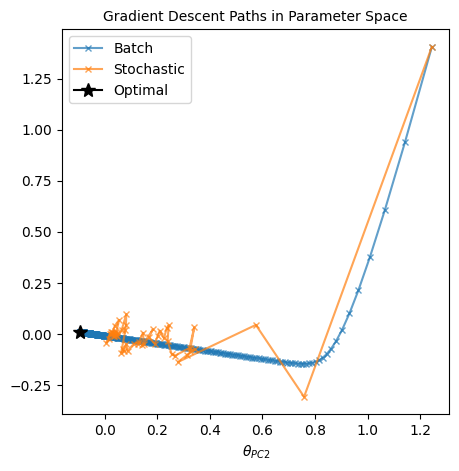

In [11]:
experiments = [
    ("Batch", bgd_regression), 
    ("Stochastic", sgd_regression)
]
ps_len = [
    len(exp[1]) for exp in experiments
]
parameter_spaces = [
    np.r_[[res[0].T for it, res in exp[1].items()]].reshape(len(exp[1]), n+1)
    for exp in experiments
]

# convert parameter space to 2D so we can visualize
pca = PCA(n_components=2)
ps_2d = pca.fit_transform(np.r_[tuple(parameter_spaces)])
theta_best_2d = pca.transform(theta_best.T)

plt.figure(figsize=(5, 5))

sx = 0
for i in range(len(experiments)):
    exp_name = experiments[i][0]
    ex = sx + ps_len[i]
    print(sx, ex)
    plt.plot(
        ps_2d[sx:ex,0],
        ps_2d[sx:ex,1],
        markersize=5,
        marker='x',
        ls='-',
        alpha=.7,
        label=exp_name
        ) 
    sx = ex

# plot the optimal theta from normal equation
plt.plot(
    theta_best_2d[0][0],
    theta_best_2d[0][1],
    marker="*",
    color="black",
    markersize=10,
    label="Optimal"
    )
plt.xlabel("$\\theta_{PC1}$")
plt.xlabel("$\\theta_{PC2}$")
plt.legend()
plt.title("Gradient Descent Paths in Parameter Space", fontsize=10)
plt.show()